In [26]:
from espnet2.asr.frontend.default import DefaultFrontend
from preprocess import F0DataNormalizer
from espnet2.train.dataset import ESPnetDataset
import soundfile as sf
import torch
import librosa.display
from model import F0EstimationModelCBS


In [27]:
frontend = DefaultFrontend(
    fs=16000,
    n_fft=1024,
    hop_length=128,
    win_length=800,
    n_mels=160,
)

In [28]:
f0data_stats_filename = "f0data/train_nodup/f0data_stats.txt"
f0data_normalizer = F0DataNormalizer(f0data_stats_filename)

In [29]:
# model_file_name = "exp/exp1/model_42500_.pth"
model_file_name = "exp/exp_tmp/model_test.pth"

model = F0EstimationModelCBS()
model.load_state_dict(torch.load(model_file_name, map_location=torch.device('cpu')))

<All keys matched successfully>

In [30]:
dataset = ESPnetDataset([("./dump/raw/eval1/wav.scp", "wav", "sound")])
# dataset = ESPnetDataset([("./dump/raw/train_dev/wav.scp", "wav", "sound")])
wav = dataset[202][1]["wav"]


In [31]:
wav_torch = torch.tensor(wav).float()
wav_torch = wav_torch.unsqueeze(0)
wav_lengths = torch.tensor([wav_torch.shape[1]])

In [32]:
inputs, input_lengths = frontend(wav_torch, wav_lengths)

In [33]:
with torch.no_grad():
    model.eval()
    f0n, df0n, vuv, output_lengths = model(inputs, input_lengths)

In [34]:
# f0n

In [35]:
f0data = f0data_normalizer.denormalize(torch.stack([f0n, df0n, f0n], dim=2))
f0 = f0data[0, :, 2]
df0 = f0data[0, :, 1]
vuv = vuv[0]

# f0data[0, :, 0] = f0data[0, :, 2]
f0data[0, vuv < 0, 0] = 0
# f0data[0, vuv < 0, 2] = 0

In [36]:
import matplotlib.pyplot as plt
import librosa
import numpy as np
import math

In [37]:
# スペクトルなどを表示するプログラム
def hz_to_mel_index(freq, n_mels=80, fmin=0, fmax=8000, htk=False):
    """周波数からメルチャネルのインデクス（実数値）を計算する．

    Args:
        freq (float or iterable): 周波数 [Hz] またはそのリスト
        n_mels (int): メルフィルタバンクの数
        fmin (float): メルスペクトログラムの最低周波数 [Hz]
        fmax (float): メルスペクトログラムの最大周波数 [Hz]
        htk (bool): HTK メルフィルタバンクを使うかどうか
    
    Returns:
        float or list: メルチャネルのインデクス（実数値）またはそのリスト
    """  
    def single_hz_to_mel_index(freq):
        if freq <= 0:
            return 0
        if freq > fmax:
            return n_mels
        mel_min = librosa.hz_to_mel(fmin, htk=htk)
        mel_max = librosa.hz_to_mel(fmax, htk=htk)
        mel = librosa.hz_to_mel(freq, htk=htk)
        idx = (mel - mel_min) / (mel_max - mel_min) * n_mels
        return idx

    if hasattr(freq, '__iter__'):
        return [single_hz_to_mel_index(f) for f in freq]
    else:
        return single_hz_to_mel_index(freq)

In [38]:
def show_mel_spectrogram(mel, ax, cmap="viridis", sr=16000, hop_length=160, fmin=0, fmax=8000, htk=False, show_xaxis=True):
    """メルスペクトログラムを表示する．

    Args:
        mel (numpy.ndarray): メルスペクトログラム
        ax (matplotlib.axes.Axes): 表示する Axes
        cmap (str): カラーマップ
        sr (int): サンプリング周波数 [Hz]
        hop_length (int): フレームの間隔
        fmin (float): メルスペクトログラムの最低周波数 [Hz]
        fmax (float): メルスペクトログラムの最大周波数 [Hz]
        htk (bool): HTK メルフィルタバンクを使うかどうか
    """    
    ax.imshow(mel, aspect="auto", origin="lower", cmap=cmap, interpolation='none',
              extent=(0, mel.shape[1]*hop_length/sr, 0, mel.shape[0]))
    
    n_mel = mel.shape[0]
    
    yticks_labels = [0] + [2**i for i in range(8, int(math.log2(sr/2))+1)] + [int(sr / 2)]
    yticks_possitions = hz_to_mel_index(yticks_labels, n_mel, fmax=sr / 2, htk=htk)

    ax.set_yticks(yticks_possitions, labels=yticks_labels)
    ax.set_ylim([0, n_mel])
    ax.set_ylabel("Frequency [Hz]")
    
    if show_xaxis:
        ax.set_xlabel("Time [sec]")
    else:
        ax.set_xticks([])

In [39]:
def show_mel_spectrogram_with_sound(sound, mel, ax_sound, ax_mel, cmap="viridis", sr=16000, hop_length=160, fmin=0, fmax=8000, htk=False, show_mel_xaxis=False):
    show_mel_spectrogram(mel, ax_mel, cmap=cmap, sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax, htk=htk, show_xaxis=show_mel_xaxis)
    librosa.display.waveshow(sound, sr=sr, ax=ax_sound, color="blue", x_axis="time")

In [40]:
def plot_processed_f0(f0, processed_f0, ax, fs=16000, hop_length=128, num_sub=4):
    pr = hop_length / fs # フレーム間隔
    t = np.arange(f0.shape[0]) * hop_length / fs    
    ax.plot(t, f0, 'k-', linewidth=0.5, label="raw f0")
    # ax.plot(t, f0, 'k*')

    if processed_f0 is not None:
        pp = hop_length / fs * num_sub # サブサンプル後のフレーム間隔
        tp = (np.arange(processed_f0.shape[0]) + 0.5 - 0.125) * pp 
        # ax.plot(tp, processed_f0[:, 2], 'o', color='none', markeredgecolor='k', label="processed f0")
        ax.plot(tp, processed_f0[:, 0], 'o', color='none', markeredgecolor='k', label="processed f0")
        for i in range(processed_f0.shape[0]):
            if processed_f0[i, 1] != 0:
                a = processed_f0[i, 1] # 傾き
                b = processed_f0[i, 2] # 切片
                if b <= 0:
                    continue
                xx = [tp[i] - pp * 0.4, tp[i] + pp * 0.4] 
                ff = (pp * 0.4) / 0.008
                yy = [a * -ff + b, a * ff + b]
                if a >= 0:
                    ax.plot(xx, yy, 'r-')
                else:
                    ax.plot(xx, yy, 'b-')
    ax.set_ylim([math.log(50), math.log(700)])
    ax.set_ylabel("log F0")
    ax.set_xlabel("Time [sec]")

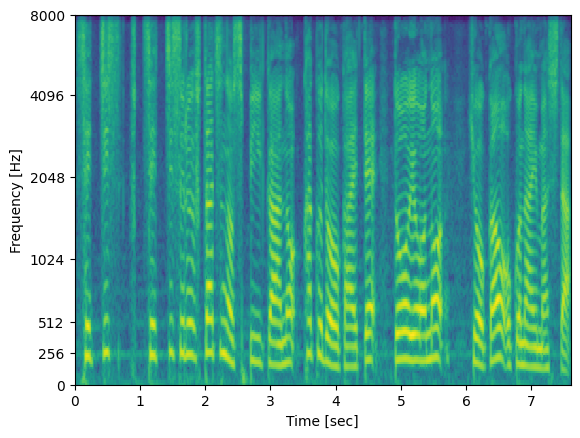

In [41]:
show_mel_spectrogram(inputs[0].numpy().T, plt.gca())

In [42]:
from espnet2.tts.feats_extract.dio import Dio 
# インスタンスの作成
dio = Dio(
    fs=16000,       # サンプリング周波数
    n_fft=1024,     # FFT点数
    hop_length=128, # フレームの間隔
    use_token_averaged_f0=False, # トークンごとの代表F0使うか（今回の場合は常にFalse）
    use_continuous_f0=False, # 連続的なF0を使うか（今回の場合は常にFalse）
    use_log_f0=True # 対数F0を使うか
)

In [43]:
f0, f0_lengths = dio(wav_torch, wav_lengths)

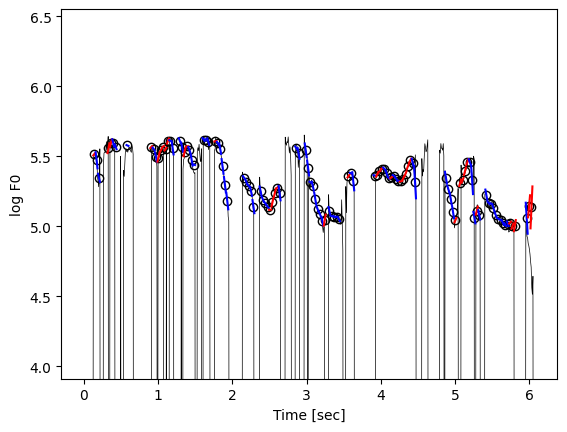

In [44]:
plot_processed_f0(f0[0].detach().numpy(), 
                  f0data[0].detach().numpy(), plt.gca())
# plt.xlim([1.2, 3.0])

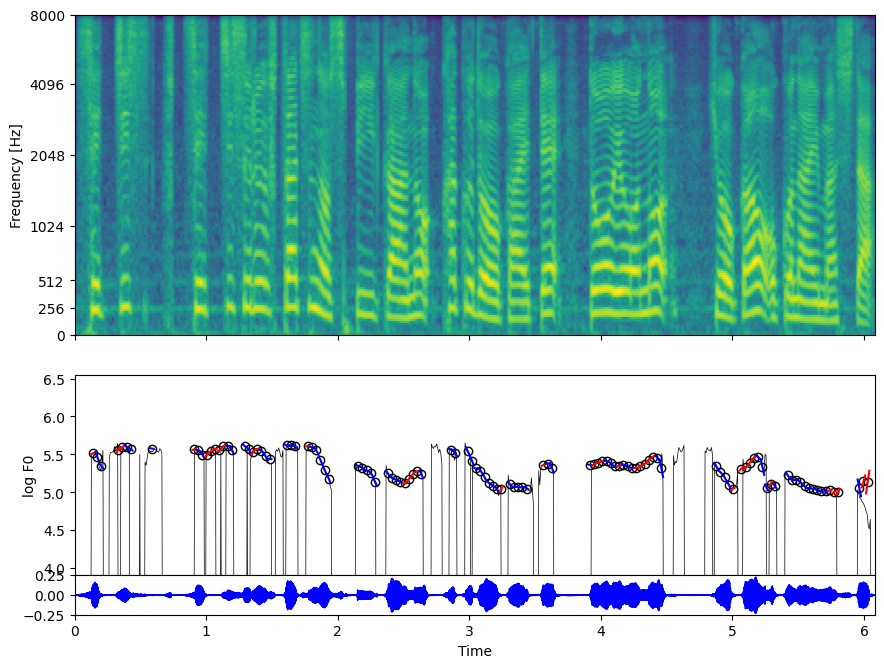

In [45]:
_, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
show_mel_spectrogram_with_sound(wav, inputs[0].numpy().T, ax[2], ax[0], 
                                sr=16000, hop_length=128, fmin=0, fmax=8000, htk=False)
plot_processed_f0(f0[0, :, 0], f0data[0].detach().numpy(), ax[1])
# ax[0].set_xlim([2, 5])
ax[0].set_position([0.1, 0.45, 0.8, 0.4])
ax[1].set_position([0.1, 0.15, 0.8, 0.25])
ax[2].set_position([0.1, 0.1,  0.8, 0.05])

# ax[0].set_xlim([3.0, 5.0])